In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress, pearsonr
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [3]:
results = []
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[8], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,2,4,8], mode='full_window')

da.load_results()

Initializing T1025-D1 ...
Results already exist
Casp ID: T1025-D1 	PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
UniProt ID: Q0H2W9
No CASP AlphaFold prediction


In [4]:
from lib.across_window_utils import (
    get_phi_psi_dist_window,
    get_xrays_window,
    get_afs_window,
    get_preds_window,
    precompute_dists,
    find_clusters,
    filter_precomputed_dists,
    calc_da_for_one_window,
    calc_da_window,
    get_cluster_medoid,
    get_target_cluster_icov,
    get_combined_phi_psi_dist
)
from lib.utils import get_phi_psi_dist

In [5]:
def plot_simple(q, phi_psi_dist, clusters=None, xrays=None, c=None):
    fig, axes = plt.subplots(1,q.winsize, figsize=(q.winsize*4,5))
    if xrays is not None:
        xrays = xrays.reshape(2, -1)
    phi_psi_dist_points = phi_psi_dist.values.reshape(phi_psi_dist.shape[0], 2, -1)
    for i in range(q.winsize):
        axes[i].scatter(phi_psi_dist_points[:,0,i], phi_psi_dist_points[:,1,i], marker='.')
        if c is not None:
            axes[i].scatter(phi_psi_dist_points[clusters==c,0,i], phi_psi_dist_points[clusters==c,1,i], c='orange', zorder=5)
        if xrays is not None:
            axes[i].scatter(xrays[0,i], xrays[1,i], c='r', marker='X', zorder=10, s=100)
        axes[i].set_xlim(-180,180)
        axes[i].set_ylim(-180,180)
    plt.show()

In [6]:
from matplotlib.patches import ConnectionPatch

def plot(q, seq, xrays, clusters, phi_psi_dist, precomputed_dists):
    n_cluster_plot = 10
    n_clusters = len(np.unique(clusters))
    xrays = xrays.reshape(2, -1)
    print(pd.Series(clusters).value_counts())

    cluster_points = phi_psi_dist.groupby(clusters).count().sort_values('phi_0', ascending=False).index.values
    clusters_plot = cluster_points[:n_cluster_plot]
    medoids = []
    for cluster in cluster_points:
        medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, cluster)
        medoids.append(medoid)
    medoids = np.array(medoids)

    colors = sns.color_palette('Dark2', n_clusters)
    fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, min(n_cluster_plot, len(clusters_plot))*4), sharey=True, sharex=True)
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    for i,axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            cluster_dist = phi_psi_dist[clusters == clusters_plot[i]]

            sns.scatterplot(data=phi_psi_dist[clusters != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
            sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
            ax.scatter(xrays[0,j], xrays[1,j], color='tab:red', marker='X', label='X-ray', zorder=1000)
            # ax.scatter(pred[0,j], pred[1,j], color='tab:orange', marker='X', label=pred_id, zorder=1000)
            ax.scatter(medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j], color='black', marker='X', label='Cluster Centroid', zorder=1000)

            def add_conn(xyA, xyB, color, lw, **kwargs):
                con = ConnectionPatch(
                    xyA=xyA, 
                    xyB=xyB, 
                    coordsA="data", coordsB="data", 
                    axesA=axrow[j], axesB=axrow[j+1], 
                    color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
                )
                fig.add_artist(con)
            if j < q.winsize - 1:
                # TODO draw lines for 50 points closest to centroid
                for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                    add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
                add_conn((xrays[0,j], xrays[1,j]), (xrays[0,j+1], xrays[1,j+1]), 'tab:red', 5, zorder=100)
                # add_conn((pred[0,j], pred[1,j]), (pred[0,j+1], pred[1,j+1]), 'tab:orange', 5, zorder=100)
                add_conn((medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j]), (medoids[i].reshape(2,-1)[0,j+1], medoids[i].reshape(2,-1)[1,j+1]), 'black', 5, zorder=100)

            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
            ax.set_xlabel('')
            if j == q.winsize - 1:
                ax.legend()
            else:
                ax.legend().remove()
            if j == 0:
                ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')

            if i == 0:
                ax.set_title(seq[j])
    fig.supxlabel('Phi')
    fig.supylabel('Psi')
    fig.suptitle(
        f'Clustered Phi/Psi Distributions for {seq} in protein {da.casp_protein_id}', 
        y=1.01
    )
    plt.tight_layout()
    plt.show()

In [7]:
da.queries[1].results.groupby('seq').size().sort_values(ascending=False)

seq
LTGIA    2569
ALREI    2470
LAEAA    1991
VLDVG    1683
AARAA    1598
         ... 
WAMES       3
PSMVR       3
PQIGY       3
LHHMP       3
SLHHM       3
Length: 262, dtype: int64

4    622
3    159
0     23
1     20
2     20
Name: count, dtype: int64


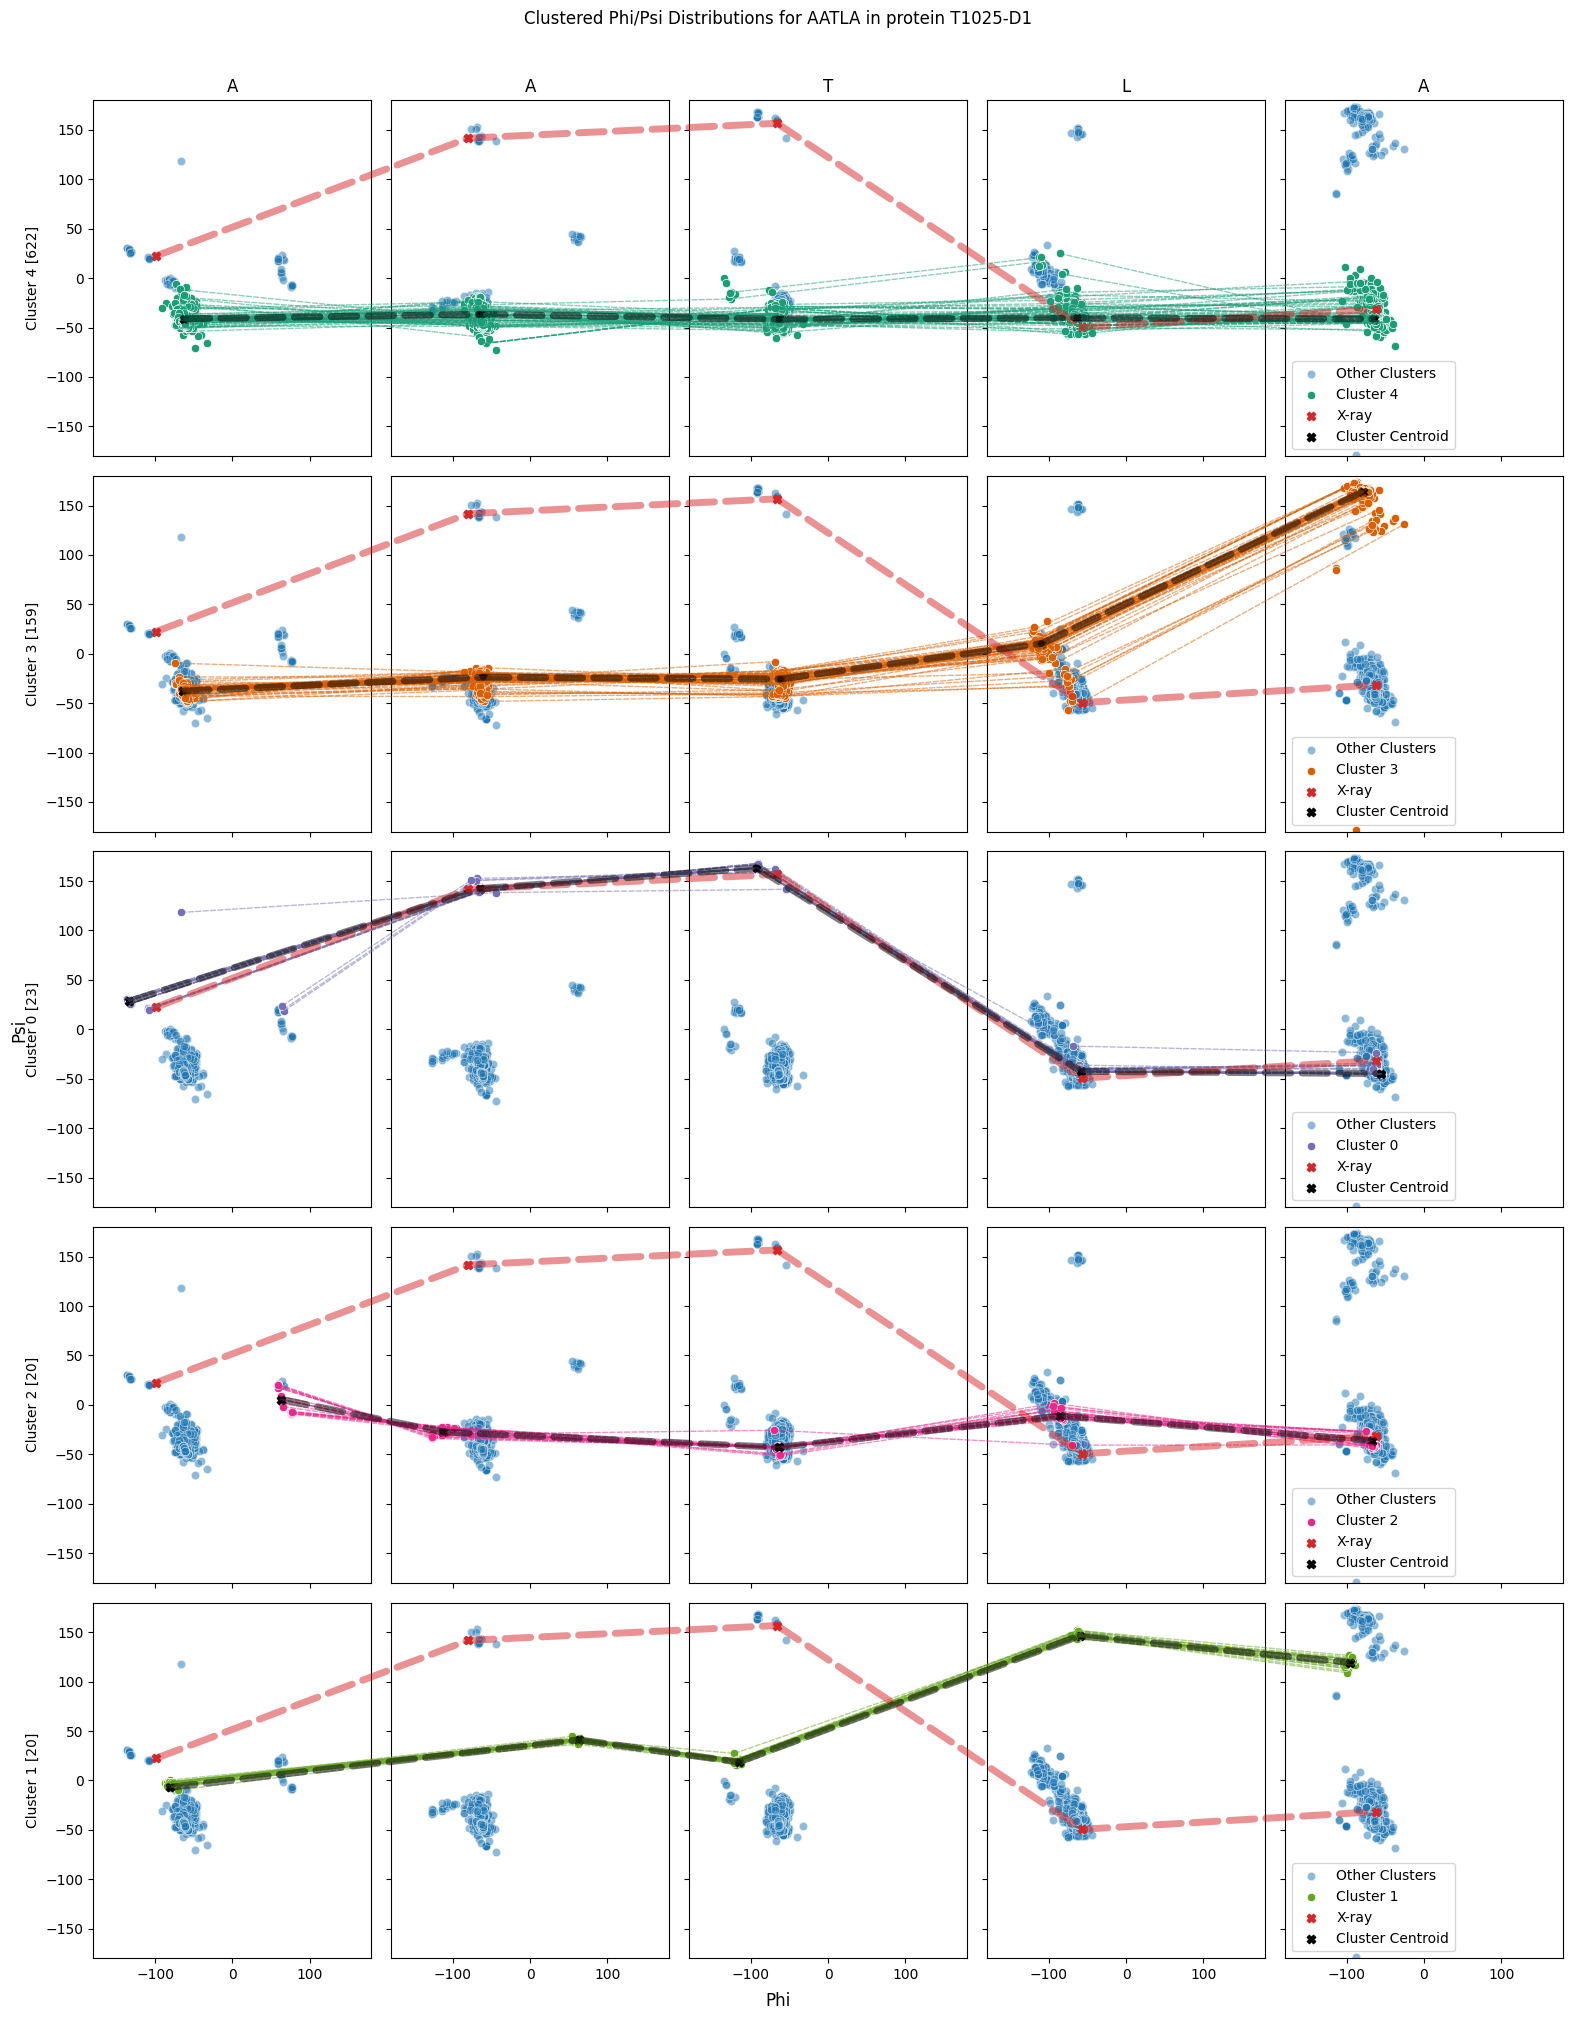

In [7]:
center_idx_ctxt = da.queries[-1].get_center_idx_pos()
winsize_ctxt = da.queries[-1].winsize
seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]
seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

# np.random.seed(0)
# seq_ctxt = np.random.choice(seqs_for_window)
# seq_ctxt = 'LTGIAEY'
seq_ctxt = seqs_for_window[18]

q = da.queries[1]
xrays = get_xrays_window(da, q, seq_ctxt)
phi_psi_dist = get_phi_psi_dist_window(q, seq_ctxt)
dists = precompute_dists(phi_psi_dist)
n_clusters, clusters = find_clusters(dists, min_cluster_size=np.min([phi_psi_dist.shape[0], 20]), cluster_selection_epsilon=30)
# n_clusters, clusters = find_clusters(dists, min_cluster_size=2, cluster_selection_epsilon=60)
# n_clusters, clusters = find_clusters(dists, min_cluster_size=2, cluster_selection_epsilon=120)
if n_clusters == 0:
    raise ValueError('No clusters found')

dists, phi_psi_dist, clusters = filter_precomputed_dists(dists, phi_psi_dist, clusters)
cluster_counts = pd.Series(clusters).value_counts().sort_values(ascending=False)
medoids = np.zeros((15, q.winsize*2))
for k,cluster in zip(range(15), cluster_counts.index):
    medoid = get_cluster_medoid(phi_psi_dist, dists, clusters, cluster)
    medoids[k] = medoid
plot(q, q.get_subseq(seq_ctxt), xrays, clusters, phi_psi_dist, dists)

In [8]:
medoids = medoids[:5]

In [48]:
def plot_simple(q, seq, phi_psi_dist, xrays, medoids, clusters):
    fig, axes = plt.subplots(1,q.winsize, figsize=(q.winsize*4,5))
    xrays = xrays.reshape(2, -1)
    medoids = medoids.reshape(medoids.shape[0], 2, -1)
    phi_psi_dist_points = phi_psi_dist.values.reshape(phi_psi_dist.shape[0], 2, -1)
    colors = sns.color_palette('Dark2', medoids.shape[0])
    for i in range(q.winsize):
        axes[i].scatter(phi_psi_dist_points[:,0,i], phi_psi_dist_points[:,1,i], marker='.')
        axes[i].scatter(xrays[0,i], xrays[1,i], c='r', marker='X', zorder=10, s=100, label='X-ray' if i == 0 else '')
        # axes[i].scatter(medoids[:,0,i], medoids[:,1,i], marker='X', zorder=10, s=100, color=colors)
        for j in range(medoids.shape[0]):
            axes[i].scatter(medoids[j,0,i], medoids[j,1,i], marker='X', zorder=10, s=100, color=colors[j], label=f'Cluster {j}' if i == 0 else '')
        axes[i].set_xlim(-180,180)
        axes[i].set_ylim(-180,180)
    
        def add_conn(xyA, xyB, color, lw, **kwargs):
            con = ConnectionPatch(
                xyA=xyA, 
                xyB=xyB, 
                coordsA="data", coordsB="data", 
                axesA=axes[i], axesB=axes[i+1], 
                color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
            )
            fig.add_artist(con)
        if i < q.winsize - 1:
            for k in range(medoids.shape[0]):
                add_conn((medoids[k,0,i], medoids[k,1,i]), (medoids[k,0,i+1], medoids[k,1,i+1]), colors[k], 5, zorder=100)
            add_conn((xrays[0,i], xrays[1,i]), (xrays[0,i+1], xrays[1,i+1]), 'tab:red', 5, zorder=100)
        axes[i].set_title(seq[i])
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=3)
    fig.suptitle('Cluster Medoids for PDBMine Query of ' + seq)
    plt.show()

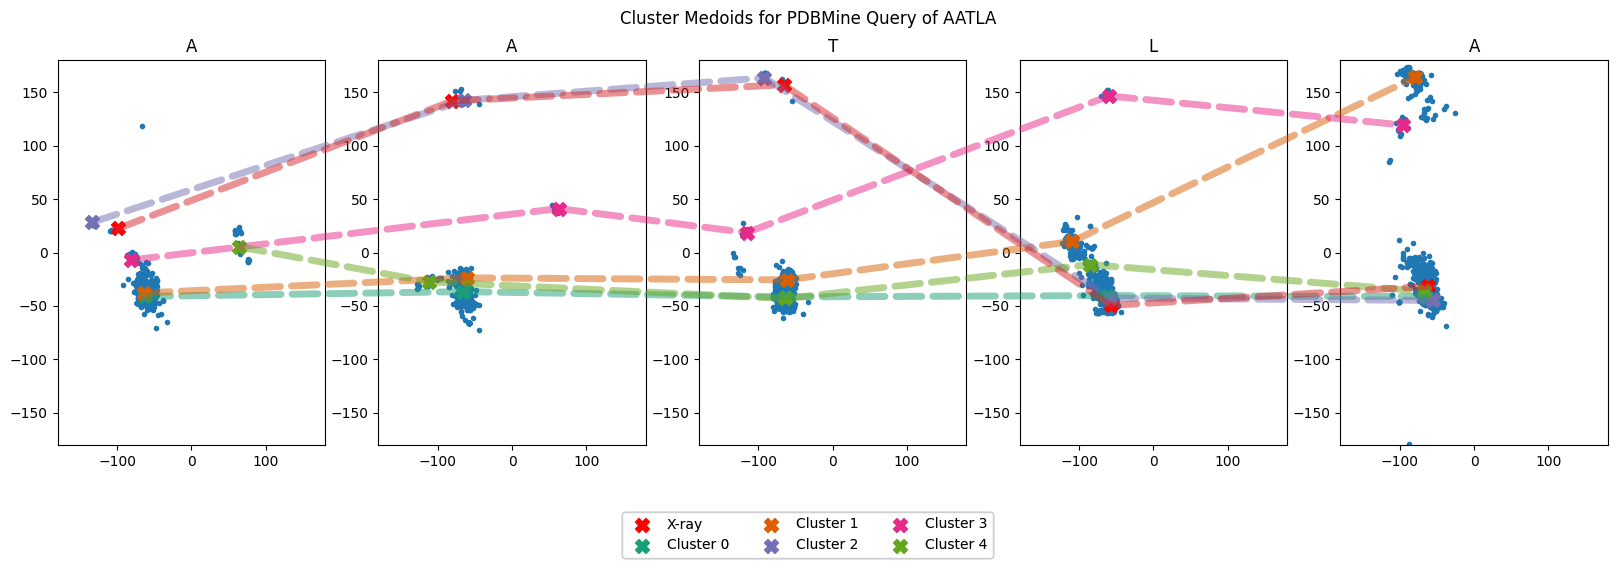

In [49]:
plot_simple(da.queries[1], q.get_subseq(seq_ctxt), phi_psi_dist, xrays, medoids, clusters)

In [46]:
for m in medoids[:5]:
    print('{ ', end='')
    for mi in m:
        print(mi, end=' ')
    print('}')

{ -62.6 -65.5 -63.4 -63.1 -64.7 -41.1 -36.6 -41.5 -40.3 -41.2 }
{ -63.2 -60.7 -61.5 -109.5 -79.3 -37.8 -23.7 -25.6 10.3 163.8 }
{ -133.5 -64.9 -92.0 -58.0 -55.1 28.3 142.3 163.3 -42.6 -44.8 }
{ -81.1 62.9 -116.0 -59.6 -96.2 -7.0 41.1 18.6 146.4 119.2 }
{ 63.6 -112.3 -64.2 -85.1 -67.1 5.4 -27.4 -43.0 -11.3 -36.3 }


In [ ]:
da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seqs_for_window[18]]

,pos,seq_ctxt,res,phi,psi,protein_id
27,30,DAATLAE,T,-66.069068,156.778582,6uv6


In [42]:
from lib.constants import AMINO_ACID_CODES_INV

In [ ]:
[AMINO_ACID_CODES_INV[r] for r in q.get_subseq(seq_ctxt)]
# 34 - 38

['ALA', 'ALA', 'THR', 'LEU', 'ALA']